In [1]:
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

Obtaining MI_prediction from git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction
  Updating ./src/mi-prediction clone
  Running command git fetch -q --tags
  Running command git reset --hard -q b7e7c358e848d47cf649a4fe8f48883c646a8442
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MI_prediction
    Found existing installation: MI-prediction 0.1
    Uninstalling MI-prediction-0.1:
      Successfully uninstalled MI-prediction-0.1
  Running setup.py develop for MI_prediction
Note: you may need to restart the kernel to use updated packages.


In [1]:
from MI_prediction.Utils.Datasets import DataLoader, DataLoader_Rest, get_epochs, get_runs, get_labels
from MI_prediction.Datasets import Cho2017_Rest, BNCI2014001_Rest
from MI_prediction.Utils.Preprocess import filterbank_preprocessor, filterbank,FBCSP
from MI_prediction.Validation.Scores import get_scores_cv, get_scores
from MI_prediction.Utils.Windowers import create_windows
from braindecode.preprocessing.preprocess import exponential_moving_standardize, preprocess, Preprocessor, scale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mne.preprocessing import compute_current_source_density

import time
import pickle

# 4Folds

## BCI2a

### Load data

In [3]:
dl = DataLoader(dataset_name="BNCI2014001")
subjects = np.arange(1,10)

In [4]:
save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/BCI2a/4Class/'

### Preprocessing

In [4]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)])

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets, ed_offsets = create_windows(win = 0.5, start_offset = -2, end_offset = 1, mi_duration = 4, overlap = 0.5)


band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


In [5]:
experiment_name = 'FB_8-15_15-25_WN_05_OV_05'

acc = {}

for s in subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])
    ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=[])
    trials = [tr.get_trials(start_offset=st_offsets, end_offset=ed_offsets) for tr in ds_f]

    acc[str(s)] = {}

    for nw in range(len(st_offsets)):
        epochs = [get_epochs(epoch['win_'+str(nw)].split('session')['session_T']) for epoch in trials]
        
        X = np.concatenate([np.expand_dims(trial[0],axis=3) for trial in epochs], axis=-1,dtype=np.float64)
        y = epochs[0][1]

        #X, y = get_labels(X,y,[0,1]) # for 2 classes

        skf = StratifiedKFold(n_splits=4)

        fbcsp = FBCSP(norm_trace=False)
        lda = LinearDiscriminantAnalysis()

        param_grid = {
                'fbcsp__n_components': [4,6,8]
                }

        clf = Pipeline([('fbcsp', fbcsp), ('lda', lda)])
        cvs = GridSearchCV(clf,param_grid=param_grid,cv=skf,scoring='accuracy',n_jobs=1, verbose=1)
        cvs.fit(X,y)

        mu, sig = get_scores_cv(cvs)
        mdl = cvs.best_estimator_
        mdl.fit(X,y)

        epochs_ts = [get_epochs(epoch['win_'+str(nw)].split('session')['session_E']) for epoch in trials]
        
        X_test = np.concatenate([np.expand_dims(trial[0],axis=3) for trial in epochs_ts], axis=-1,dtype=np.float64)
        y_test = epochs_ts[0][1]

        #X_test, y_test = get_labels(X_test,y_test,[0,1]) # for 2 classes

        ypred = mdl.predict(X_test)
        acc_ts = accuracy_score(y_test,ypred)

        acc[str(s)]['win_'+str(nw)]={
                'acc_train': mu,
                'std_train': sig,
                'acc_test': acc_ts,
                'model': mdl
                }
        
        print("Accuracy train: {}  Accuracy test: {}  elapsed: {}".format(mu,acc_ts, time.time()-tic))

        pickle.dump(acc, open(save_path+experiment_name+'.pkl', 'wb'))

Subject: 1


### FB: (8,15) (15,25) WN: 0.5 OV: 0.5

In [6]:
experiment_name = 'FB_8-15_15-25_WN_05_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [7]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [8]:
acc

,subject,window,accuracy,std
0,1,win_0,0.493056,0.056843
1,1,win_1,0.479167,0.086458
2,1,win_2,0.555556,0.051967
3,1,win_3,0.500000,0.092128
4,1,win_4,0.548611,0.079483
...,...,...,...,...
238,9,win_22,0.618056,0.030270
239,9,win_23,0.506944,0.045538
240,9,win_24,0.597222,0.108476
241,9,win_25,0.611111,0.058926


### FB: (8,15) (15,25) WN: 1 OV: 0.5

In [6]:
experiment_name = 'FB_8-15_15-25_WN_1_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [7]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [13]:
acc

,subject,window,accuracy,std
0,1,win_0,0.246528,0.106400
1,1,win_1,0.256944,0.054238
2,1,win_2,0.256944,0.037397
3,1,win_3,0.250000,0.065881
4,1,win_4,0.520833,0.048611
...,...,...,...,...
112,9,win_8,0.444444,0.035410
113,9,win_9,0.336806,0.046455
114,9,win_10,0.315972,0.060838
115,9,win_11,0.309028,0.064680


### FB: (8,15) (15,25) WN: 1.5 OV: 0.5

In [40]:
experiment_name = 'FB_8-15_15-25_WN_15_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [41]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [42]:
acc

,subject,window,accuracy,std
0,1,win_0,0.270833,0.060937
1,1,win_1,0.274306,0.033123
2,1,win_2,0.440972,0.045405
3,1,win_3,0.715278,0.028633
4,1,win_4,0.708333,0.074794
...,...,...,...,...
67,9,win_3,0.666667,0.089473
68,9,win_4,0.635417,0.070393
69,9,win_5,0.406250,0.026671
70,9,win_6,0.357639,0.024797


### FB: (8,15) (15,25) WN: 2 OV: 0.5

In [27]:
experiment_name = 'FB_8-15_15-25_WN_2_OV_05'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [28]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [29]:
acc

,subject,window,accuracy,std
0,1,win_0,0.298611,0.039893
1,1,win_1,0.329861,0.060040
2,1,win_2,0.718750,0.053228
3,1,win_3,0.774306,0.063930
4,1,win_4,0.677083,0.040937
5,1,win_5,0.486111,0.072169
6,2,win_0,0.239583,0.039741
7,2,win_1,0.267361,0.039741
8,2,win_2,0.416667,0.077951
9,2,win_3,0.552083,0.093363


### FB: (8,15) (15,25) WN: 4 OV: 0

In [19]:
experiment_name = 'FB_8-15_15-25_WN_4_OV_0'
data = pickle.load( open( save_path+experiment_name+'.pkl', "rb" ) )

In [20]:
acc = get_scores(data,'train')
acc_ts = get_scores(data,'test')

In [21]:
acc

,subject,window,accuracy,std
0,1,win_0,0.767361,0.024797
1,2,win_0,0.597222,0.068041
2,3,win_0,0.711806,0.090211
3,4,win_0,0.423611,0.082461
4,5,win_0,0.416667,0.072169
5,6,win_0,0.489583,0.091801
6,7,win_0,0.802083,0.069009
7,8,win_0,0.795139,0.088047
8,9,win_0,0.597222,0.058101


In [45]:
acc_ts

,subject,window,accuracy,std
0,1,win_0,0.965278,None
1,2,win_0,0.819444,None
2,3,win_0,0.888889,None
3,4,win_0,0.791667,None
4,5,win_0,0.604167,None
5,6,win_0,0.784722,None
6,7,win_0,0.798611,None
7,8,win_0,0.791667,None
8,9,win_0,0.854167,None


[]

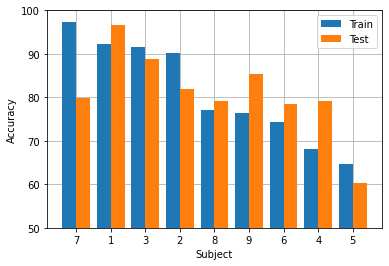

In [48]:
idx = np.argsort(acc['accuracy'])[::-1]
plt.bar(acc['subject']-0.2,acc['accuracy'][idx]*100,width=0.4,label='Train')
plt.bar(acc_ts['subject']+0.2,acc_ts['accuracy'][idx]*100,width=0.4,label='Test')
plt.xticks(acc['subject'],acc['subject'][idx])
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.ylim([50,100])
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True) 
plt.plot()

In [17]:
acc

{'1': 0.9236111111111112,
 '2': 0.923611111111111,
 '3': 0.9791666666666666,
 '4': 0.6319444444444444,
 '5': 0.6458333333333334,
 '6': 0.7291666666666667,
 '7': 0.9652777777777779,
 '8': 0.7777777777777779,
 '9': 0.7638888888888888}

In [51]:
acc #(8,12) (12,38)

{'1': 0.923611111111111,
 '2': 0.9166666666666666,
 '3': 0.923611111111111,
 '4': 0.736111111111111,
 '5': 0.6388888888888888,
 '6': 0.7291666666666666,
 '7': 0.9722222222222223,
 '8': 0.7847222222222221,
 '9': 0.763888888888889}

In [42]:
acc # Con laplaciano

{'1': 0.9027777777777778,
 '2': 0.9097222222222222,
 '3': 0.9305555555555556,
 '4': 0.6805555555555556,
 '5': 0.5416666666666666,
 '6': 0.6388888888888888,
 '7': 0.9513888888888888,
 '8': 0.8680555555555556,
 '9': 0.7083333333333333}

In [39]:
acc # sin laplaciano

{'1': 0.9097222222222222,
 '2': 0.8958333333333334,
 '3': 0.9444444444444444,
 '4': 0.7013888888888888,
 '5': 0.5277777777777778,
 '6': 0.6319444444444444,
 '7': 0.9444444444444444,
 '8': 0.8680555555555556,
 '9': 0.7569444444444444}

## GIGAscience Cho2017

In [69]:
dl = DataLoader(dataset_name="Cho2017")

subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

In [70]:
save_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/GIGA/2Class/'

### Preprocess and CSP

In [76]:
fb = filterbank_preprocessor([(8.,15.),(15.,25.)])

preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        #Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
        Preprocessor('filter',l_freq=1., h_freq=None)
        ]

Ch_prep = [
        Preprocessor(compute_current_source_density,copy=False,apply_on_array=False)
        ]

st_offsets, ed_offsets = create_windows(win = 3, start_offset = 0, end_offset = 0, mi_duration = 3, overlap = 0.0)


band to filter: (8.0, 15.0) Hz
band to filter: (15.0, 25.0) Hz


In [77]:
experiment_name = 'FB_8-15_15-25_WN_3_OV_05/'

acc = {}

for s in [7]:#subjects:
    print ("Subject: {}".format(s))
    tic = time.time()

    dl.load_data(subject_ids=[s])
    ds_f = filterbank(dl, preprocess=preprocessors, filters=fb, channels_prep=Ch_prep)
    trials = [tr.get_trials(start_offset=st_offsets, end_offset=ed_offsets) for tr in ds_f]

    acc[str(s)] = {}

    for nw in range(len(st_offsets)):
        epochs = [get_epochs(epoch['win_'+str(nw)].split('session')['session_0']) for epoch in trials]
        
        X = np.concatenate([np.expand_dims(trial[0],axis=3) for trial in epochs], axis=-1,dtype=np.float64)
        y = epochs[0][1]

        skf = StratifiedKFold(n_splits=4)

        fbcsp = FBCSP(norm_trace=False)
        lda = LinearDiscriminantAnalysis()

        param_grid = {
                'fbcsp__n_components': [3,6,8]
                }

        clf = Pipeline([('fbcsp', fbcsp), ('lda', lda)])
        cvs = GridSearchCV(clf,param_grid=param_grid,cv=skf,scoring='accuracy',n_jobs=-1, verbose=1)
        cvs.fit(X,y)

        mu, sig = get_scores_cv(cvs)
        mdl = cvs.best_estimator_
        mdl.fit(X,y)

        acc[str(s)]['win_'+str(nw)]={
                'acc_train': mu,
                'std_train': sig,
                'acc_test': None,
                'model': mdl
                }
        
        print("Accuracy train: {}  Accuracy test: {}  elapsed: {}".format(mu,None, time.time()-tic))

        #pickle.dump(acc, open(save_path+experiment_name+'S'+str(s)+'.pkl', 'wb'))

Subject: 7


Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


240 events found
Event IDs: [1 2]
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Fitted sphere radius:         96.2 mm
Origin head coordinates:      -0.8 14.4 43.1 mm
Origin device coordinates:    -0.8 14.4 43.1 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz 

In [75]:
acc

{'7': {'win_0': {'acc_train': 0.48750000000000004,
   'std_train': 0.024650332429581746,
   'acc_test': None,
   'model': Pipeline(steps=[('fbcsp', FBCSP(n_components=6)),
                   ('lda', LinearDiscriminantAnalysis())])}}}

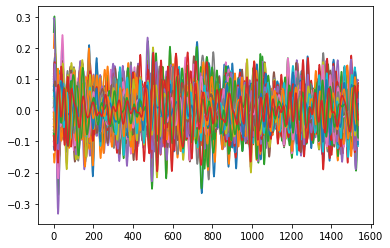

In [57]:
plt.plot(X[0,:,:,0].T)
plt.show()

In [62]:
cvs.cv_results_

{'mean_fit_time': array([3.71218425, 3.97557759, 3.86950821]),
 'std_fit_time': array([0.0562465 , 0.30060401, 0.06283241]),
 'mean_score_time': array([0.02016723, 0.0352959 , 0.03294319]),
 'std_score_time': array([0.00560978, 0.01815521, 0.00913525]),
 'param_fbcsp__n_components': masked_array(data=[4, 6, 8],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'fbcsp__n_components': 4},
  {'fbcsp__n_components': 6},
  {'fbcsp__n_components': 8}],
 'split0_test_score': array([0.51666667, 0.48333333, 0.5       ]),
 'split1_test_score': array([0.41666667, 0.45      , 0.55      ]),
 'split2_test_score': array([0.38333333, 0.43333333, 0.41666667]),
 'split3_test_score': array([0.45      , 0.51666667, 0.5       ]),
 'mean_test_score': array([0.44166667, 0.47083333, 0.49166667]),
 'std_test_score': array([0.04930066, 0.03200477, 0.04787136]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

### FB: (8,15) (15,25) WN: 3 OV: 0

In [58]:
experiment_name = 'FB_8-15_15-25_WN_3_OV_0/'
data = pickle.load( open( save_path+experiment_name+'S43'+'.pkl', "rb" ) )

In [59]:
data

{'43': {'win_0': {'acc_train': 0.955,
   'std_train': 0.04555216789572149,
   'acc_test': None,
   'model': Pipeline(steps=[('fbcsp', FBCSP()), ('lda', LinearDiscriminantAnalysis())])}}}

# Load results

## BCI2a

In [130]:
experiment_names = [
    'FB_8-15_15-25_WN_4_OV_0',
    'FB_8-15_15-25_WN_2_OV_05',
    'FB_8-15_15-25_WN_15_OV_05',
    'FB_8-15_15-25_WN_1_OV_05',
    'FB_8-15_15-25_WN_05_OV_05',
    ]
wins = [
    '4.0',
    '2.0',
    '1.5',
    '1.0',
    '0.5',
    ]

In [131]:
load_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/BCI2a/2Class/'

### Train

In [132]:
acc = {}

for ex in range(len(experiment_names)):
    data = pickle.load(open(load_path+experiment_names[ex]+'.pkl', 'rb'))
    if ex == 0:
        acc['subjects'] = list(map(int,list(data.keys())))
    acc[wins[ex]] = [np.max([data[x][w]['acc_train']for w in data[x].keys()]) for x in data.keys()]
pickle.dump(acc, open(load_path+'acc_train.pkl', 'wb'))

In [109]:
acc = pd.DataFrame(acc)
acc.sort_values(by='4.0',inplace=True, ascending=False,ignore_index=True)

In [110]:
acc

,subjects,4.0,2.0,1.5,1.0,0.5
0,7,0.972222,0.965278,0.986111,0.972222,0.944444
1,1,0.923611,0.937500,0.902778,0.930556,0.937500
2,3,0.916667,0.875000,0.847222,0.833333,0.791667
3,2,0.902778,0.965278,0.937500,0.923611,0.868056
4,8,0.770833,0.750000,0.763889,0.763889,0.736111
5,9,0.763889,0.840278,0.861111,0.895833,0.902778
6,6,0.743056,0.729167,0.715278,0.763889,0.722222
7,4,0.680556,0.659722,0.659722,0.687500,0.736111
8,5,0.645833,0.680556,0.722222,0.798611,0.743056


In [111]:
ACC = acc.melt(id_vars=['subjects'], value_vars=['4.0','2.0','1.5','1.0','0.5'], var_name='win_length', value_name='accuracy')

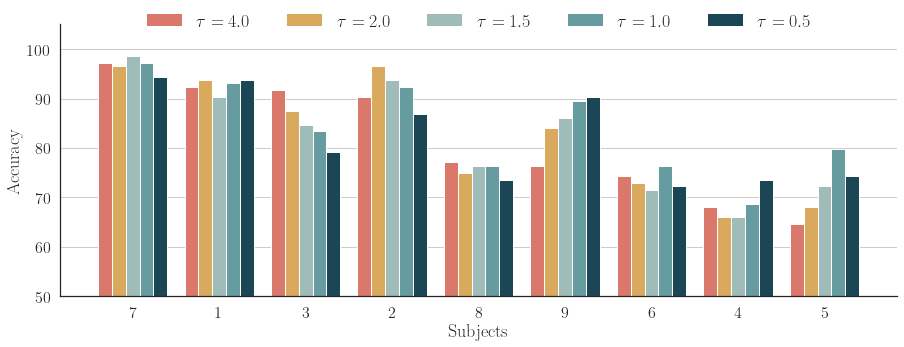

In [115]:
img_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Figs/BCI2a/2Class/'
fs = 18
fs_tkz = 16
plt.figure(figsize=(15,5))
sns.set(style='white')
plt.rc('text', usetex=True)
plt.rc('font', family='Computer Modern Roman')
plt.rc('font', size=fs)
#colors = ["#CACAAA", "#EEC584", '#C8AB83', '#55868C', '#7F636E']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#2F4858']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(x="subjects", y="accuracy", hue='win_length', data=ACC, order=acc['subjects'], palette=customPalette)
ax.set_axisbelow(True)
plt.grid(True,axis='y')
plt.xlabel('Subjects', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
h, l = ax.get_legend_handles_labels()
ax.legend(h,[r'$\tau = 4.0$',r'$\tau = 2.0$', r'$\tau = 1.5$', r'$\tau = 1.0$', r'$\tau = 0.5$'], loc='upper center', ncol=5, bbox_to_anchor =(0.5,1.1), fontsize=fs, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.linspace(0.5,1,6),np.linspace(50,100,6,dtype=int),fontsize=fs_tkz)
plt.xticks(fontsize=fs_tkz)
plt.axis('tight')
plt.ylim([.5,1.05])
plt.savefig(img_path+'acc_train.svg', bbox_inches='tight', format='svg', dpi = 300)
plt.savefig(img_path+'acc_train.eps', bbox_inches='tight', format='eps', dpi = 300)
plt.show()

### Test

In [133]:
acc = {}

for ex in range(len(experiment_names)):
    data = pickle.load(open(load_path+experiment_names[ex]+'.pkl', 'rb'))
    if ex == 0:
        acc['subjects'] = list(map(int,list(data.keys())))
    acc[wins[ex]] = [np.max([data[x][w]['acc_test']for w in data[x].keys()]) for x in data.keys()]
pickle.dump(acc, open(load_path+'acc_test.pkl', 'wb'))

In [117]:
acc = pd.DataFrame(acc)
acc.sort_values(by='4.0',inplace=True, ascending=False,ignore_index=True)

In [118]:
ACC = acc.melt(id_vars=['subjects'], value_vars=['4.0','2.0','1.5','1.0','0.5'], var_name='win_length', value_name='accuracy')

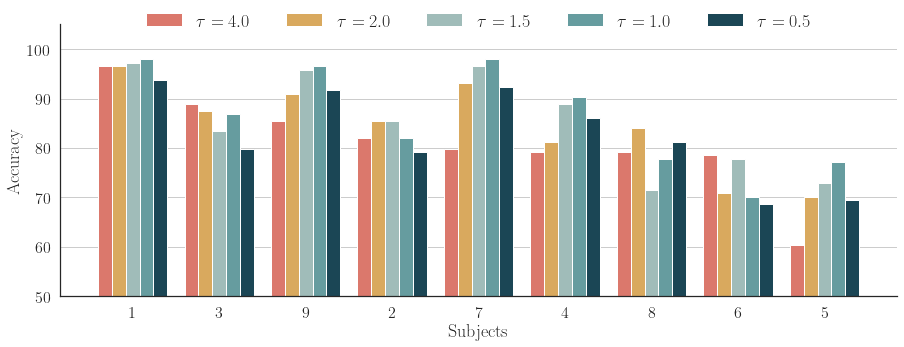

In [119]:
img_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Figs/BCI2a/2Class/'
fs = 18
fs_tkz = 16
plt.figure(figsize=(15,5))
sns.set(style='white')
plt.rc('text', usetex=True)
plt.rc('font', family='Computer Modern Roman')
plt.rc('font', size=fs)
#colors = ["#CACAAA", "#EEC584", '#C8AB83', '#55868C', '#7F636E']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#2F4858']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(x="subjects", y="accuracy", hue='win_length', data=ACC, order=acc['subjects'], palette=customPalette)
ax.set_axisbelow(True)
plt.grid(True,axis='y')
plt.xlabel('Subjects', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
h, l = ax.get_legend_handles_labels()
ax.legend(h,[r'$\tau = 4.0$',r'$\tau = 2.0$', r'$\tau = 1.5$', r'$\tau = 1.0$', r'$\tau = 0.5$'], loc='upper center', ncol=5, bbox_to_anchor =(0.5,1.1), fontsize=fs, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.linspace(0.5,1,6),np.linspace(50,100,6,dtype=int),fontsize=fs_tkz)
plt.xticks(fontsize=fs_tkz)
plt.axis('tight')
plt.ylim([.5,1.05])
plt.savefig(img_path+'acc_test.svg', bbox_inches='tight', format='svg', dpi = 300)
plt.savefig(img_path+'acc_test.eps', bbox_inches='tight', format='eps', dpi = 300)
plt.show()

## GIGAScience Cho2017

In [134]:
experiment_names = [
    'FB_8-15_15-25_WN_3_OV_0',
    'FB_8-15_15-25_WN_2_OV_05',
    'FB_8-15_15-25_WN_15_OV_05',
    'FB_8-15_15-25_WN_1_OV_05',
    'FB_8-15_15-25_WN_05_OV_05',
    ]
wins = [
    '3.0',
    '2.0',
    '1.5',
    '1.0',
    '0.5',
    ]

In [135]:
load_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Results/GIGA/2Class/'

In [94]:
subjects = np.arange(1,53)
subjects = subjects[(subjects!=32) & (subjects!=46) & (subjects!=49)]

acc = {}

for ex in range(len(experiment_names)):
    data = {}
    for s in subjects:
        data_s = pickle.load(open(load_path+experiment_names[ex]+'/S'+str(s)+'.pkl', 'rb'))
        data[str(s)] = data_s[str(s)]
    pickle.dump(data, open(load_path+experiment_names[ex]+'.pkl', 'wb'))

/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/julian/miniforge3/envs/MI_pred/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [136]:
acc = {}

for ex in range(len(experiment_names)):
    data = pickle.load(open(load_path+experiment_names[ex]+'.pkl', 'rb'))
    if ex == 0:
        acc['subjects'] = list(map(int,list(data.keys())))
    acc[wins[ex]] = [np.max([data[x][w]['acc_train']for w in data[x].keys()]) for x in data.keys()]
pickle.dump(acc, open(load_path+'acc_train.pkl', 'wb'))

In [123]:
pd.DataFrame(acc)

,subjects,3.0,2.0,1.5,1.0,0.5
0,1,0.715000,0.775000,0.745000,0.665000,0.660000
1,2,0.510000,0.535000,0.515000,0.545000,0.540000
2,3,0.815000,0.965000,0.975000,0.950000,0.900000
3,4,0.595000,0.625000,0.640000,0.655000,0.580000
4,5,0.720000,0.775000,0.715000,0.730000,0.665000
5,6,0.775000,0.775000,0.735000,0.810000,0.720000
6,7,0.483333,0.487500,0.529167,0.558333,0.558333
7,8,0.495000,0.577857,0.590000,0.600000,0.660000
8,9,0.533333,0.608333,0.544280,0.579167,0.604167
9,10,0.590000,0.620000,0.610000,0.640000,0.640000


In [124]:
acc = pd.DataFrame(acc)
acc.sort_values(by='3.0',inplace=True, ascending=False,ignore_index=True)

In [125]:
ACC = acc.melt(id_vars=['subjects'], value_vars=['3.0','2.0','1.5','1.0','0.5'], var_name='win_length', value_name='accuracy')

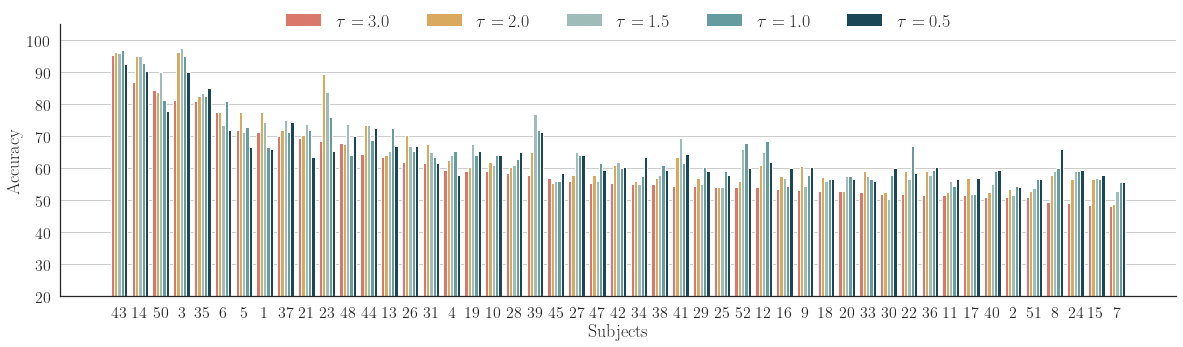

In [126]:
img_path = '/Volumes/GoogleDrive/Mi unidad/PhD_Thesis/Figs/GIGA/2Class/'
fs = 18
fs_tkz = 16
plt.figure(figsize=(20,5))
sns.set(style='white')
plt.rc('text', usetex=True)
plt.rc('font', family='Computer Modern Roman')
plt.rc('font', size=fs)
#colors = ["#CACAAA", "#EEC584", '#C8AB83', '#55868C', '#7F636E']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#2F4858']
#colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
colors = ["#ED6A5A", "#EDAE49", '#9BC1BC', '#5CA4A9', '#114B5F']
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(x="subjects", y="accuracy", hue='win_length', data=ACC, order=acc['subjects'], palette=customPalette)
ax.set_axisbelow(True)
plt.grid(True,axis='y')
plt.xlabel('Subjects', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)
h, l = ax.get_legend_handles_labels()
ax.legend(h,[r'$\tau = 3.0$',r'$\tau = 2.0$', r'$\tau = 1.5$', r'$\tau = 1.0$', r'$\tau = 0.5$'], loc='upper center', ncol=5, bbox_to_anchor =(0.5,1.1), fontsize=fs, frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.linspace(0.2,1,9),np.linspace(20,100,9,dtype=int),fontsize=fs_tkz)
plt.xticks(fontsize=fs_tkz)
plt.axis('tight')
plt.ylim([.2,1.05])
plt.savefig(img_path+'acc_train.svg', bbox_inches='tight', format='svg', dpi = 300)
plt.savefig(img_path+'acc_train.eps', bbox_inches='tight', format='eps', dpi = 300)
plt.show()